<a href="https://colab.research.google.com/github/Lakshaykumarr28/Skin-Disease-Detection/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Lakshaykumarr28/Skin-Disease-Detection

Cloning into 'Skin-Disease-Detection'...
remote: Enumerating objects: 11336, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 11336 (delta 64), reused 85 (delta 44), pack-reused 11218 (from 1)
Receiving objects: 100% (11336/11336), 2.87 GiB | 73.30 MiB/s, done.
Resolving deltas: 100% (778/778), done.
Updating files: 100% (11211/11211), done.


Importing necessary libraries

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob

from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf

from keras.utils import plot_model
from tensorflow.keras.metrics import Recall

from tensorflow.keras import layers
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

import pickle

# The Dataset



HAM10000_metadata.csv file is the main csv file that includes the data of all training images, the features of which are -
1. Lesion_id
2. Image_id
3. Dx
4.  Dx_type
5.  Age
6.  Sex
7.  Localization



In [3]:
# Reading the data from HAM_metadata.csv
df = pd.read_csv('/content/Skin-Disease-Detection/archive/HAM10000_metadata.csv')

In [4]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
df.dtypes

,0
lesion_id,object
image_id,object
dx,object
dx_type,object
age,float64
sex,object
localization,object


In [6]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


A statistical analysis of numerical attributes of the dataset (age)

### Data Cleaning and Management

Removing NULL values from the dataset

In [7]:
df.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0


There are 57 NULL values in 'age' feature.
Rather than dropping the values, replacing NULL values with the mean of 'age'.

In [8]:
df['age'].fillna( df['age'].mean()  , inplace = True)

<ipython-input-8-1fde7e3c45a7>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna( df['age'].mean()  , inplace = True)


In [9]:
df.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,0
sex,0
localization,0


All NULL values are now resolved.

Now, Making a lesion type dictionary to map the lesion type to a dataframe column.

In [10]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

base_skin_dir = '/content/Skin-Disease-Detection/archive'

# Merge images from both folders into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [11]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/Skin-Disease-Detection/archive/HAM100...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/Skin-Disease-Detection/archive/HAM100...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/Skin-Disease-Detection/archive/HAM100...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/Skin-Disease-Detection/archive/HAM100...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/Skin-Disease-Detection/archive/HAM100...,Benign keratosis-like lesions,2


# Image Preprocessing

We have to resize the images from dimensions : 400 * 600 * 3 to dimensions : 150 * 120 * 3 as the model might take a lot of time to run on large dimensions of images.

In [12]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

Plotting some images from each class of dataset.

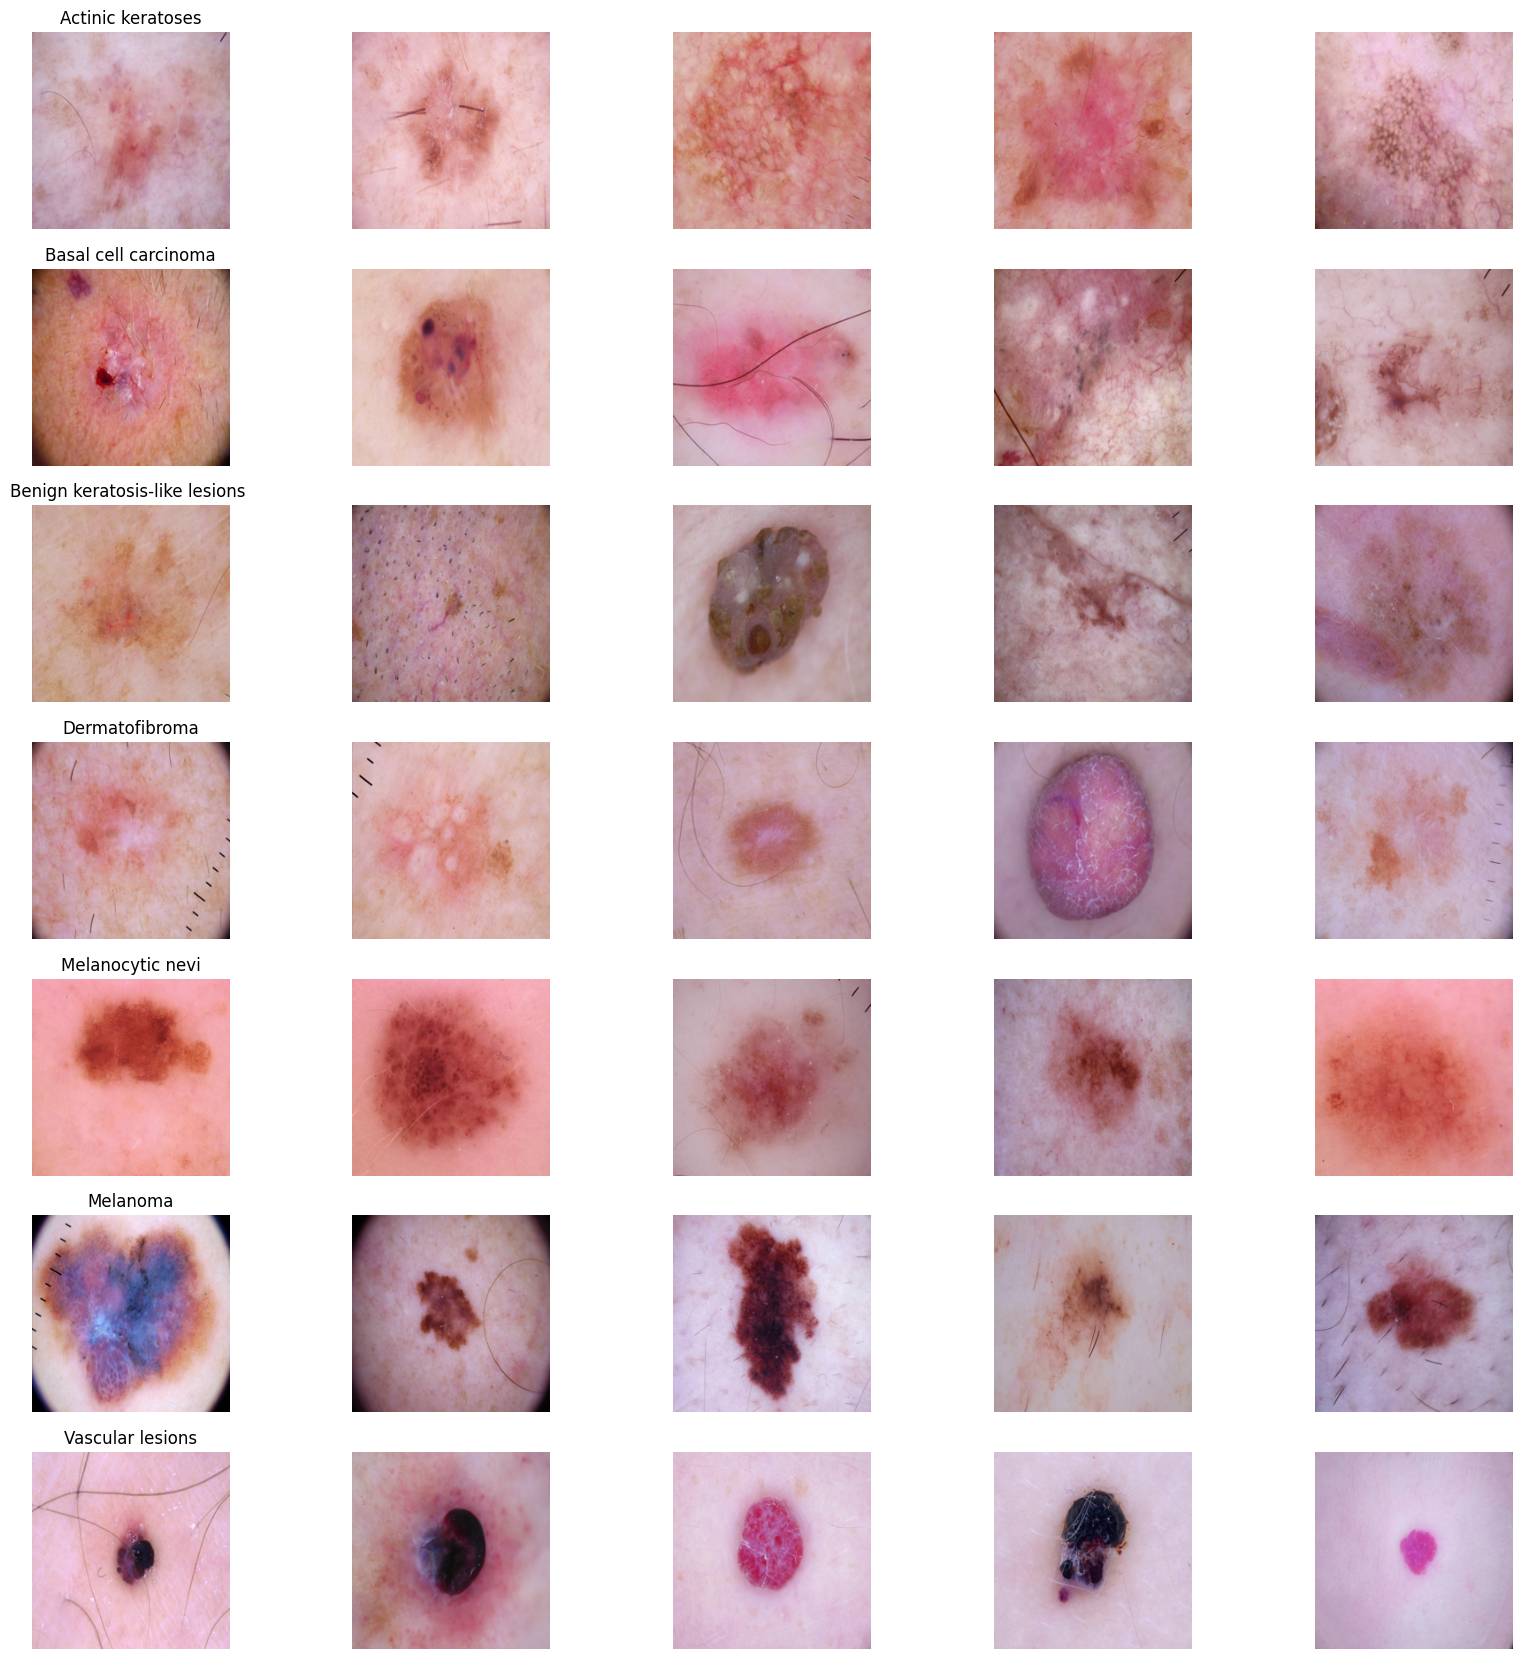

In [13]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [14]:
# to check the image size distribution - It returns one row that shows all images are uniform
df['image'].map(lambda x: x.shape).value_counts()

,count
image,
"(224, 224, 3)",10015


In [15]:
features = df.drop(columns = ['cell_type_idx'], axis = 1)
target = df['cell_type_idx']

features.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/Skin-Disease-Detection/archive/HAM100...,Benign keratosis-like lesions,"[[[187, 150, 192], [190, 154, 195], [192, 156,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/Skin-Disease-Detection/archive/HAM100...,Benign keratosis-like lesions,"[[[24, 13, 22], [25, 13, 23], [24, 14, 23], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/Skin-Disease-Detection/archive/HAM100...,Benign keratosis-like lesions,"[[[186, 127, 135], [188, 129, 137], [191, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/Skin-Disease-Detection/archive/HAM100...,Benign keratosis-like lesions,"[[[23, 11, 15], [24, 11, 18], [24, 10, 19], [2..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/Skin-Disease-Detection/archive/HAM100...,Benign keratosis-like lesions,"[[[125, 83, 105], [132, 89, 112], [138, 93, 11..."


In [16]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.25,random_state=666)
unique_values = tf.unique(x_train_o.cell_type.values)

In [17]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [18]:
# Performing one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [19]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)

# Reshaping images in 3 dimensions (height = 60, width = 75 , channel = 3)
x_train = x_train.reshape(x_train.shape[0], *(224,224,3))
x_test = x_test.reshape(x_test.shape[0], *(224,224,3))
x_validate = x_validate.reshape(x_validate.shape[0], *(224,224,3))

In [20]:
np.ma.shape(x_train)

(6759, 224, 224, 3)

In [21]:
np.ma.shape(x_test)

(2504, 224, 224, 3)

In [22]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [23]:
np.ma.shape(x_train)

(6759, 224, 224, 3)

# InceptionV3

In [24]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [25]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Load the InceptionV3 model, without the top (final classification) layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling reduces each feature map to a single value
x = Dense(1024, activation='relu')(x)  # Add a dense layer for more learnable parameters
predictions = Dense(7, activation='softmax')(x)  # 7 classes for skin diseases

# Combine base model and new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers to retain pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Compile model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Rescale pixel values from 0-255 to 0-1
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Train model
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction
)

# Optionally, unfreeze some layers of the InceptionV3 base model for fine-tuning
for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers
    layer.trainable = True

# Recompile model after unfreezing layers
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune model
history_finetune = model.fit(x=x_train,
                             y=y_train,
                             epochs=5,
                             batch_size=32,
                             validation_data=(x_validate,y_validate),
                             callbacks=learning_rate_reduction
)


87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/10
212/212 [==============================] - 56s 245ms/step - loss: 0.9371 - accuracy: 0.6869 - val_loss: 0.8733 - val_accuracy: 0.6689 - lr: 1.0000e-04
Epoch 2/10
212/212 [==============================] - 47s 222ms/step - loss: 0.7509 - accuracy: 0.7292 - val_loss: 0.8469 - val_accuracy: 0.6782 - lr: 1.0000e-04
Epoch 3/10
212/212 [==============================] - 50s 234ms/step - loss: 0.6818 - accuracy: 0.7500 - val_loss: 0.8654 - val_accuracy: 0.6848 - lr: 1.0000e-04
Epoch 4/10
212/212 [==============================] - 50s 238ms/step - loss: 0.6289 - accuracy: 0.7685 - val_loss: 0.8287 - val_accuracy: 0.6968 - lr: 1.0000e-04
Epoch 5/10
212/212 [==============================] - 49s 234ms/step - loss: 0.5699 - accuracy: 0.7923 - val_loss: 0.8581 - val_accuracy: 0.6835 - lr: 1.0000e-04
Epoch 6/10
212/212 [==============================] - 49s 232ms/step - loss: 0.5267 - accuracy: 0.8074 - val_loss: 0.8140 - v

In [26]:
accuracy = model.evaluate(x_train, y_train, verbose=1)[1]
print("Train accuracy = ", accuracy*100, "%")

212/212 [==============================] - 41s 195ms/step - loss: 0.0783 - accuracy: 0.9962
Train accuracy =  99.61532950401306 %


In [27]:
accuracy = model.evaluate(x_test, y_test, verbose=1)[1]
print("Test: accuracy = ",accuracy*100,"%")

79/79 [==============================] - 15s 193ms/step - loss: 0.8243 - accuracy: 0.7328
Test: accuracy =  73.28274846076965 %


Saving the model

In [28]:
model.save('inceptionv3_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Predicting the class of a sample image. image class = "Benign keratosis-like lesions"

In [29]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the saved model
model = load_model('/content/inceptionv3_model.h5')

# Define the class indices dictionary
class_indices = {
    0: 'Melanocytic nevi',
    1: 'Melanoma',
    2: 'Benign keratosis-like lesions',
    3: 'Basal cell carcinoma',
    4: 'Actinic keratoses',
    5: 'Vascular lesions',
    6: 'Dermatofibroma'
}

# Load and preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Target size for InceptionV3
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale pixel values to [0, 1]
    return img_array

# Predict the class of a new image
def predict_image_class(img_path):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)  # Predict the class probabilities
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the index of highest probability
    class_name = class_indices[predicted_class]  # Map index to class name
    return class_name

# Example usage
img_path = '/content/ISIC_0024313.jpg'
class_name = predict_image_class(img_path)
print(f"Predicted Class: {class_name}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/ISIC_0024313.jpg'

# MobileNet V2

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set parameters
input_shape = (224, 224, 3)
num_classes = 7

# Load the MobileNetV2 model with pre-trained ImageNet weights, exclude the top layer
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model's layers
base_model.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)  # Adding dropout to reduce overfitting
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)  # Additional dropout layer
predictions = Dense(num_classes, activation='softmax')(x)  # Final layer for classification

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model
epochs = 10  # You can adjust the number of epochs
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction
)

# Unfreeze some layers and fine-tune
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze the first 100 layers
    layer.trainable = False

# Re-compile and fine-tune
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_epochs = 5
history_finetune = model.fit(x=x_train,
                             y=y_train,
                             epochs=5,
                             batch_size=32,
                             validation_data=(x_validate,y_validate),
                             callbacks=learning_rate_reduction
)


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
212/212 [==============================] - 52s 235ms/step - loss: 0.8831 - accuracy: 0.7063 - val_loss: 0.7535 - val_accuracy: 0.6995 - lr: 0.0010
Epoch 2/10
212/212 [==============================] - 47s 223ms/step - loss: 0.6774 - accuracy: 0.7565 - val_loss: 0.7467 - val_accuracy: 0.6981 - lr: 0.0010
Epoch 3/10
212/212 [==============================] - 48s 227ms/step - loss: 0.6165 - accuracy: 0.7770 - val_loss: 0.7254 - val_accuracy: 0.7301 - lr: 0.0010
Epoch 4/10
212/212 [==============================] - 48s 229ms/step - loss: 0.5613 - accuracy: 0.7850 - val_loss: 0.7451 - val_accuracy: 0.7061 - lr: 0.0010
Epoch 5/10
212/212 [==============================] - 45s 215ms/step - loss: 0.5216 - accuracy: 0.8075 - val_loss: 0.6806 - val_accuracy: 0.7487 - lr: 0.0010
Epoch 6/10
212/212 [==============================] - 49s 229ms/step - loss: 0.4826 - accuracy: 0.8217 - val_loss: 0.6639 - val_accuracy: 0.7460 - 

In [31]:
accuracy = model.evaluate(x_train, y_train, verbose=1)[1]
print("Train accuracy = ", accuracy*100, "%")

212/212 [==============================] - 43s 203ms/step - loss: 0.3788 - accuracy: 0.8568
Train accuracy =  85.67835688591003 %


In [32]:
accuracy = model.evaluate(x_test, y_test, verbose=1)[1]
print("Test: accuracy = ",accuracy*100,"%")

79/79 [==============================] - 16s 196ms/step - loss: 0.7313 - accuracy: 0.7736
Test: accuracy =  77.35623121261597 %


Saving the model

In [33]:
model.save('MobileNetV2_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Implementation of CNN

The CNN model : DenseNet 121

Optimizer: SGD

Activation function used: Softmax

In [34]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Load the DenseNet121 model without the top layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of DenseNet121
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling reduces each feature map to a single value
x = Dense(1024, activation='relu')(x)  # Dense layer for more learnable parameters
predictions = Dense(7, activation='softmax')(x)  # 7 classes for skin diseases

# Combine base model and new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers to retain pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Compile model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Rescale pixel values from 0-255 to 0-1
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_validate, y_validate),
    callbacks=[learning_rate_reduction]
)

# Optionally, unfreeze some layers of the DenseNet121 base model for fine-tuning
for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers
    layer.trainable = True

# Recompile model after unfreezing layers
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune model
history_finetune = model.fit(
    x=x_train,
    y=y_train,
    epochs=5,
    batch_size=32,
    validation_data=(x_validate, y_validate),
    callbacks=[learning_rate_reduction]
)


29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/10
212/212 [==============================] - 148s 674ms/step - loss: 0.8795 - accuracy: 0.6964 - val_loss: 0.7912 - val_accuracy: 0.6995 - lr: 1.0000e-04
Epoch 2/10
212/212 [==============================] - 139s 657ms/step - loss: 0.6995 - accuracy: 0.7466 - val_loss: 0.7336 - val_accuracy: 0.7154 - lr: 1.0000e-04
Epoch 3/10
212/212 [==============================] - 144s 681ms/step - loss: 0.6362 - accuracy: 0.7722 - val_loss: 0.6994 - val_accuracy: 0.7274 - lr: 1.0000e-04
Epoch 4/10
212/212 [==============================] - 140s 658ms/step - loss: 0.5905 - accuracy: 0.7896 - val_loss: 0.6788 - val_accuracy: 0.7314 - lr: 1.0000e-04
Epoch 5/10
212/212 [==============================] - 136s 643ms/step - loss: 0.5574 - accuracy: 0.7985 - val_loss: 0.6673 - val_accuracy: 0.7434 - lr: 1.0000e-04
Epoch 6/10
212/212 [==============================] - 139s 657ms/step - loss: 0.5252 - accuracy: 0.8097 - val_loss: 0.64

In [35]:
accuracy = model.evaluate(x_train, y_train, verbose=1)[1]
print("Train accuracy = ", accuracy*100, "%")

212/212 [==============================] - 114s 539ms/step - loss: 0.3528 - accuracy: 0.8806
Train accuracy =  88.06036114692688 %


In [36]:
accuracy = model.evaluate(x_test, y_test, verbose=1)[1]
print("Test: accuracy = ",accuracy*100,"%")

79/79 [==============================] - 42s 531ms/step - loss: 0.5900 - accuracy: 0.7919
Test: accuracy =  79.19328808784485 %


In [37]:
model.save('DenseNet121_model.h5')